In [1]:
import os
import json
from glob import glob

from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%time
df_order = pd.read_csv("orders.csv")
df_order_detail = pd.concat([
    pd.read_csv("order_products__prior.csv"),
    pd.read_csv("order_products__train.csv")
])

CPU times: user 3.6 s, sys: 939 ms, total: 4.54 s
Wall time: 4.73 s


In [39]:
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [3]:
df_order_detail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 1.3 GB


In [4]:
df_product = (
    pd.read_csv("products.csv")
    .merge(pd.read_csv("aisles.csv"), on="aisle_id", how="left")
    .merge(pd.read_csv("departments.csv"), on="department_id", how="left")
    .drop(["aisle_id", "department_id"], axis=1)
)

In [5]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_id    49688 non-null  int64 
 1   product_name  49688 non-null  object
 2   aisle         49688 non-null  object
 3   department    49688 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


In [6]:
df_product.product_id.max()

49688

In [7]:
df_order_detail.order_id = df_order_detail.order_id.astype(np.int32)
df_order_detail.product_id = df_order_detail.product_id.astype(np.int32)
df_order_detail.add_to_cart_order = df_order_detail.add_to_cart_order.astype(np.int16)
df_order_detail.reordered = df_order_detail.reordered.astype(bool)

df_product.aisle = df_product.aisle.astype("category")
df_product.department = df_product.department.astype("category")

### 구매의 시작과 끝은 무슨 상품이 될까?
- 구매의 시작이 되는 상품을 프로모션하면 매출 증대에 도움이 될 수 있다
- 구매의 끝이 되는 상품은 결제 직전에 노출함으로써 매출 증대에 도움이 될 수 있다

In [8]:
df_order_detail = df_order_detail.merge(df_product, on="product_id", how="left")

**첫 구매**

In [16]:
df_first_order = df_order_detail[df_order_detail.add_to_cart_order == 1]

In [17]:
department_count = pd.concat([
    df_first_order.groupby("department").size(), 
    df_last_order.groupby("department").size(), 
    df_order_detail.groupby("department").size()
], axis=1)
department_count.columns = ["first", "last", "total"]
department_count = department_count.assign(
    last_ratio = department_count["last"] / department_count["total"],
    first_ratio = department_count["first"] / department_count["total"]
)

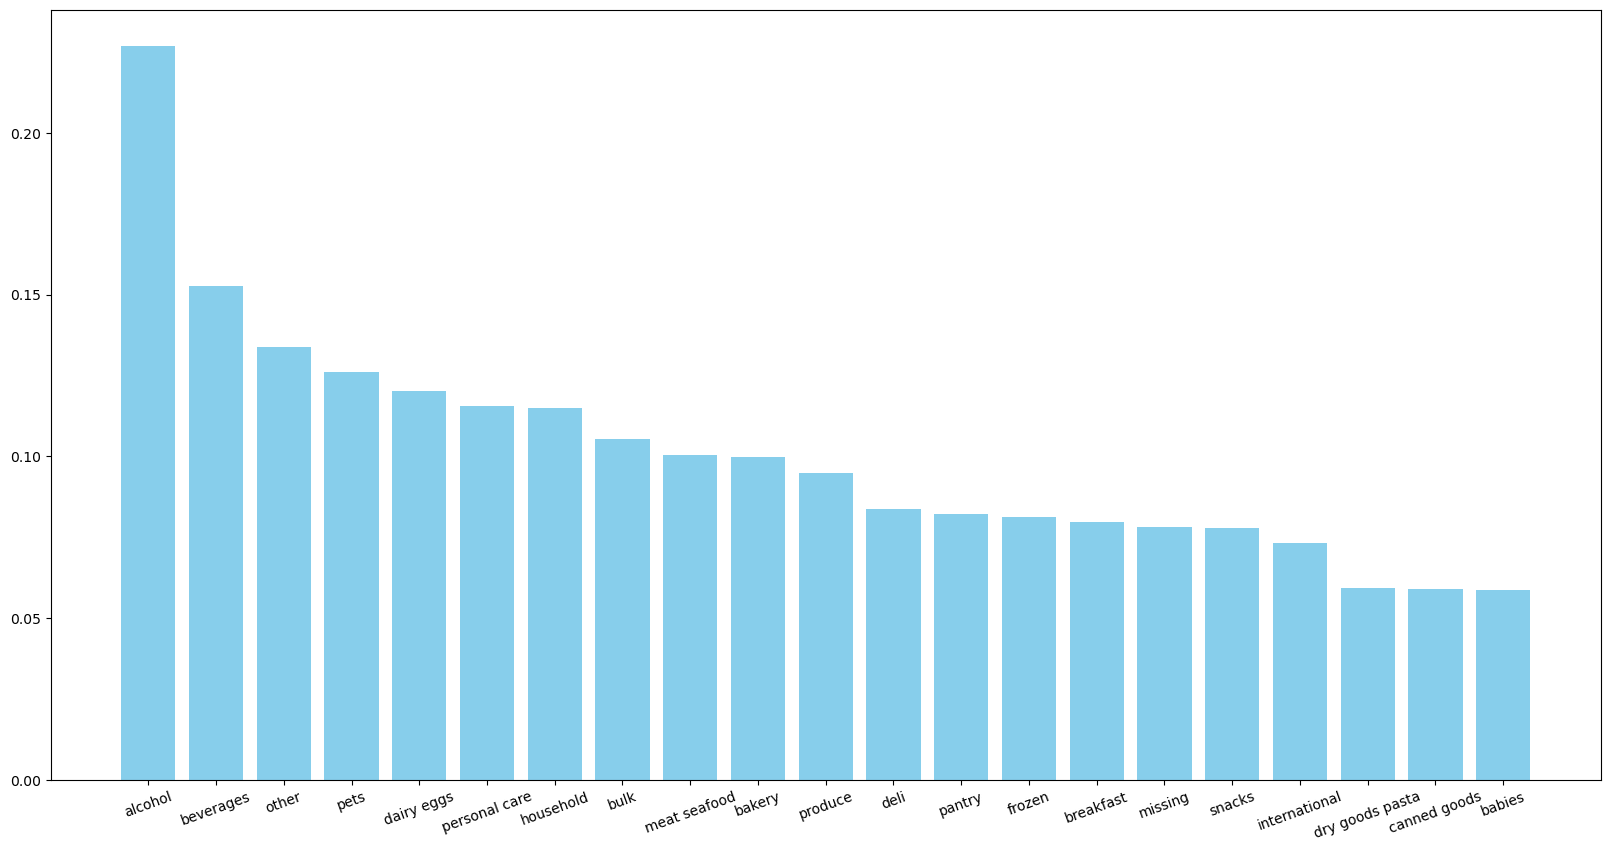

In [18]:
department_count = department_count.sort_values("first_ratio", ascending=False)
plt.figure(figsize=(20,10))
plt.bar(department_count.index, department_count.first_ratio, color="skyblue")
plt.xticks(rotation=20)
plt.show()

**마지막 구매**

In [9]:
%%time
df_order_detail = df_order_detail.sort_values(["order_id", "add_to_cart_order"])
df_order_detail = df_order_detail.reset_index(drop=True)

CPU times: user 4.76 s, sys: 1.49 s, total: 6.25 s
Wall time: 6.72 s


In [10]:
# %%time
# df_last_order = pd.concat([
#     group.nlargest(1, "add_to_cart_order") 
#     for order_id, group in 
#     tqdm(
#         df_order_detail.groupby("order_id"), 
#         total=df_order_detail.order_id.nunique()
#     )
# ])

In [11]:
# %%time

# def get_largest(group):
#     return group.nlargest(1, "add_to_cart_order")


# df_last_order = pd.concat(
#     Parallel(n_jobs=-1)(
#         delayed(get_largest)(group) 
#         for order_id, group in 
#         tqdm(df_order_detail.groupby("order_id"), total=df_order_detail.order_id.nunique())
#     )
# )

In [12]:
%%time
df_last_order = df_order_detail.groupby("order_id").tail(1)
df_last_order

CPU times: user 1.68 s, sys: 489 ms, total: 2.17 s
Wall time: 2.17 s


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle,department
7,1,22035,8,True,Organic Whole String Cheese,packaged cheese,dairy eggs
16,2,43668,9,False,Classic Blend Cole Slaw,packaged vegetables fruits,produce
24,3,32665,8,True,Organic Ezekiel 49 Bread Cinnamon Raisin,bread,bakery
37,4,41276,13,True,Energy Drink,energy sports drinks,beverages
63,5,8479,26,False,Original Black Box Tablewater Cracker,crackers,snacks
...,...,...,...,...,...,...,...
33819072,3421079,30136,1,False,Moisture Soap,soap,personal care
33819081,3421080,38061,9,False,Organic Raw Coconut Butter,butter,dairy eggs
33819088,3421081,12861,7,False,Farmer’s Market Vine Ripened Tomato & Basil Hu...,fresh dips tapenades,deli
33819095,3421082,47941,7,False,Special K Red Berries Cereal,cereal,breakfast


In [13]:
df_last_order[df_last_order.order_id == 53]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle,department
457,53,46194,15,False,Burrata,packaged cheese,dairy eggs


In [14]:
# df_last_order = df_last_order[df_last_order.add_to_cart_order >= 7]

In [15]:
# %%time
# from pandas.testing import assert_frame_equal

# assert_frame_equal(df_last_order2.reset_index(drop=True), df_last_order)

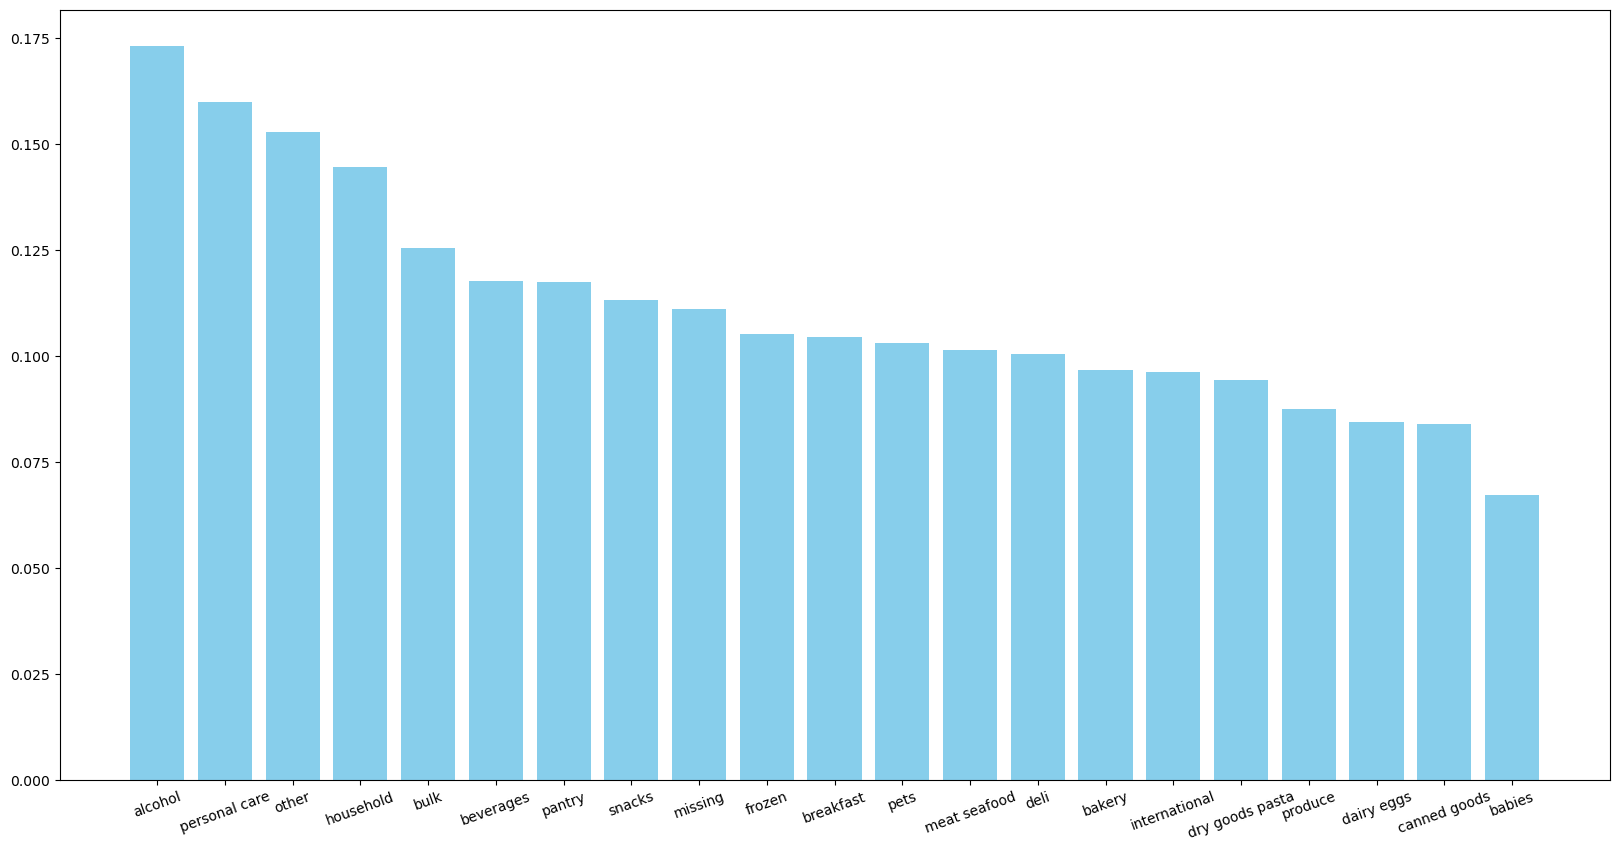

In [19]:
department_count = department_count.sort_values("last_ratio", ascending=False)
plt.figure(figsize=(20,10))
plt.bar(department_count.index, department_count.last_ratio, color="skyblue")
plt.xticks(rotation=20)
plt.show()

In [20]:
department_count[["last_ratio", "first_ratio"]].corr()

,last_ratio,first_ratio
last_ratio,1.000000,0.706881
first_ratio,0.706881,1.000000


In [27]:
department_count

,first,last,total,last_ratio,first_ratio
department,,,,,
alcohol,36118,27554,159294,0.172976,0.226738
personal care,54172,74927,468693,0.159864,0.115581
other,5100,5819,38086,0.152786,0.133907
household,88929,111947,774652,0.144513,0.114799
bulk,3780,4504,35932,0.125348,0.105199
beverages,427869,330186,2804175,0.117748,0.152583
pantry,160846,229697,1956819,0.117383,0.082198
snacks,233966,340391,3006412,0.113222,0.077822
missing,6046,8587,77396,0.110949,0.078118


### 상품 구매 순서에 의미가 있을까?
- 예를 들어 alcohol 직후에 많은 구매가 이어지는 상품이 있다면, 연관 상품으로 볼 수 있음

In [21]:
# seqs = []
# for _, group in tqdm(df_order_detail.groupby("order_id")):
#     aisle_unique = group.aisle.drop_duplicates()
#     df_seq = pd.concat([aisle_unique.shift(1), aisle_unique], axis=1)
#     df_seq = df_seq.dropna()
#     df_seq.columns = ["before", "after"]
#     seqs.append(df_seq)

In [22]:
partition_count = 199
df_order_detail = df_order_detail.assign(partition = df_order_detail.order_id%partition_count)

In [23]:
%%time
for partition, group in df_order_detail.groupby("partition"):
    group.to_parquet(f"./order_seq/raw_{partition}.parquet")

CPU times: user 9.25 s, sys: 673 ms, total: 9.93 s
Wall time: 10.2 s


In [24]:
def _seq_agg(group):
    aisle_unique = group.aisle.drop_duplicates()
    df_seq = pd.concat([aisle_unique.shift(1), aisle_unique], axis=1)
    df_seq.columns = ["before", "after"]
    return df_seq
    
def seq_agg(df_temp):
    seqs = Parallel(n_jobs=-1)(delayed(_seq_agg)(group) for _, group in df_temp.groupby("order_id"))
    df_seq = pd.concat(seqs)
    df_agg = df_seq.groupby(["before", "after"]).size().reset_index(name="cnt")
    return df_agg

In [25]:
if os.path.exists("seq_progress.json"):
    dict_progress = json.load(open("seq_progress.json", "r"))
else:
    dict_progress = {}
    
n_total = len(glob("./order_seq/raw_*"))
n_done = len(dict_progress)
n_ratio = n_done / n_total
print(f"Done: {n_done:,}({n_ratio*100:.2f}%)")

Done: 54(27.14%)


In [28]:
for path in tqdm(glob("./order_seq/raw_*")):
    if path in dict_progress:
        continue
    
    df_temp = pd.read_parquet(path)
    df_agg_temp = seq_agg(df_temp)
    df_agg_temp.to_parquet(f"./order_seq/agg_{partition}.parquet")
    dict_progress[path] = True
    json.dump(dict_progress, open("seq_progress.json", "w"))

In [29]:
df_agg = pd.concat([pd.read_parquet(path) for path in glob("./order_seq/agg_*")])
df_agg = df_agg[df_agg.cnt != 0]

In [30]:
df_agg

,before,after,cnt
1,air fresheners candles,asian foods,1
8,air fresheners candles,beauty,1
10,air fresheners candles,body lotions soap,1
12,air fresheners candles,breakfast bakery,1
15,air fresheners candles,bulk grains rice dried goods,1
...,...,...,...
17948,yogurt,tofu meat alternatives,19
17949,yogurt,tortillas flat bread,28
17950,yogurt,trail mix snack mix,7
17952,yogurt,vitamins supplements,2


In [31]:
df_order_detail.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle,department,partition
0,1,49302,1,True,Bulgarian Yogurt,yogurt,dairy eggs,1
1,1,11109,2,True,Organic 4% Milk Fat Whole Milk Cottage Cheese,other creams cheeses,dairy eggs,1
2,1,10246,3,False,Organic Celery Hearts,fresh vegetables,produce,1
3,1,49683,4,False,Cucumber Kirby,fresh vegetables,produce,1
4,1,43633,5,True,Lightly Smoked Sardines in Olive Oil,canned meat seafood,canned goods,1


In [32]:
df_aisle = df_order_detail[["aisle", "add_to_cart_order"]].assign(aisle_before = df_order_detail.aisle.shift(1))
df_aisle = df_aisle[df_aisle.add_to_cart_order != 1]
df_aisle = df_aisle.rename(columns = {"aisle":"aisle_after"})
df_aisle = df_aisle[df_aisle.aisle_before != df_aisle.aisle_after]
df_aisle_agg = df_aisle.groupby(["aisle_before", "aisle_after"]).size().reset_index(name="cnt")

In [33]:
df_aisle_agg = df_aisle_agg[df_aisle_agg.cnt > 0]

In [34]:
df_aisle_agg.nlargest(10, "cnt")

,aisle_before,aisle_after,cnt
6753,fresh fruits,fresh vegetables,427678
7152,fresh vegetables,fresh fruits,391429
6798,fresh fruits,packaged vegetables fruits,283475
13185,packaged vegetables fruits,fresh vegetables,269676
7200,fresh vegetables,packaged vegetables fruits,262350
13182,packaged vegetables fruits,fresh fruits,258107
6833,fresh fruits,yogurt,150489
17872,yogurt,fresh fruits,143124
11172,milk,fresh fruits,122273
6783,fresh fruits,milk,102581


In [38]:
df_order_detail

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle,department,partition
0,1,49302,1,True,Bulgarian Yogurt,yogurt,dairy eggs,1
1,1,11109,2,True,Organic 4% Milk Fat Whole Milk Cottage Cheese,other creams cheeses,dairy eggs,1
2,1,10246,3,False,Organic Celery Hearts,fresh vegetables,produce,1
3,1,49683,4,False,Cucumber Kirby,fresh vegetables,produce,1
4,1,43633,5,True,Lightly Smoked Sardines in Olive Oil,canned meat seafood,canned goods,1
...,...,...,...,...,...,...,...,...
33819101,3421083,39678,6,True,Free & Clear Natural Dishwasher Detergent,dish detergents,household,74
33819102,3421083,11352,7,False,Organic Mini Sandwich Crackers Peanut Butter,crackers,snacks,74
33819103,3421083,4600,8,False,All Natural French Toast Sticks,frozen breakfast,frozen,74
33819104,3421083,24852,9,True,Banana,fresh fruits,produce,74


In [43]:
(df_order.user_id % 13 == 1).sum()

262312

In [40]:
df_order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [41]:
df_order_detail.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle,department,partition
0,1,49302,1,True,Bulgarian Yogurt,yogurt,dairy eggs,1
1,1,11109,2,True,Organic 4% Milk Fat Whole Milk Cottage Cheese,other creams cheeses,dairy eggs,1
2,1,10246,3,False,Organic Celery Hearts,fresh vegetables,produce,1
3,1,49683,4,False,Cucumber Kirby,fresh vegetables,produce,1
4,1,43633,5,True,Lightly Smoked Sardines in Olive Oil,canned meat seafood,canned goods,1
